In [2]:
import os
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.stats
from IPython.parallel import Client
from scipy.stats import norm
from scipy.stats import beta
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os.path as op
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

//anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [3]:
# rc = Client() #only do this once

In [4]:
#generate some choices
k_eqs = np.linspace(.0001, .05, 100)
a_ss = [10, 20, 30]
d_ss = [0, 14, 28]
d_ll = [14, 28, 42]

data = {'amountSS':[], 'amountLL':[],'delaySS':[], 'delayLL':[], 'k_eq':[]}
for k in k_eqs:
    SS = np.random.choice(a_ss)
    dSS = np.random.choice(d_ss)
    dLL = 0
    while dLL <= dSS:
        dLL = np.random.choice(d_ll)
        
    LL = (SS * 1.0/ (1 + k*dSS)) * (1 + k*dLL)
    
    data['amountSS'].append(SS)
    data['amountLL'].append(LL)
    data['delaySS'].append(dSS)
    data['delayLL'].append(dLL)
    data['k_eq'].append(k)
data = pd.DataFrame(data)
data['k_eq'].mean()

0.02504999999999999

# Now let's define some key functions for the hyperbolic model and model fitting

In [17]:
def flip(p):
    return 'SS' if rd.random() < p else 'LL'

In [18]:
def hyperbolic(A,d,k):
    return A * 1.0/(1.0+k*d)

In [109]:
def run_simulation(params,sub_df):
    k,m = params
    choices = []
    for i in range(sub_df.shape[0]):
        SV_SS = hyperbolic(sub_df.loc[i,'amountSS'],
                            sub_df.loc[i,'delaySS'],
                            k)
        SV_LL = hyperbolic(sub_df.loc[i,'amountLL'],
                            sub_df.loc[i,'delayLL'],
                            k)
        p = 1 / (1 + np.exp(-1*m*(SV_SS-SV_LL)) )
        choices.append(flip(p))
        
    return choices

In [110]:
def get_LL(params,sub_df):
    k,m = params
    LL = 0
    for i in range(sub_df.shape[0]):
        SV_SS = hyperbolic(sub_df.loc[i,'amountSS'],
                            sub_df.loc[i,'delaySS'],
                            k)
        SV_LL = hyperbolic(sub_df.loc[i,'amountLL'],
                            sub_df.loc[i,'delayLL'],
                            k)

        p = 1 / (1 + np.exp(-1*m*(SV_SS-SV_LL)) )

        if sub_df.loc[i,'choice'] == 'LL':
            p = 1-p
        LL += np.log(p)
    return -1*LL

# Visualize likelihood energy function for choices around a typical k,m

In [5]:
df = []
for i in range(100):

    ks = np.linspace(.02,.03,41) 
    ms = np.linspace(1,3, 41)
    LL = []
    k_idx = []
    m_idx = []

    #simulate data
    params = (.025,2)
    data['choice'] = run_simulation(params,data)

    #get LL for other ks, ms
    for m in ms:
        for k in ks:
            ll = get_LL((k,m),data)
            LL.append(ll)
            k_idx.append(k)
            m_idx.append(m)  
    sub_df = pd.DataFrame({'ks':k_idx,'LL':LL, 'm':m_idx, 'i':i})
    df.append(sub_df.copy())
df = pd.concat(df)

In [223]:
df['LL'] = df['LL']*-1
df = df.groupby(['ks','m']).mean().reset_index()

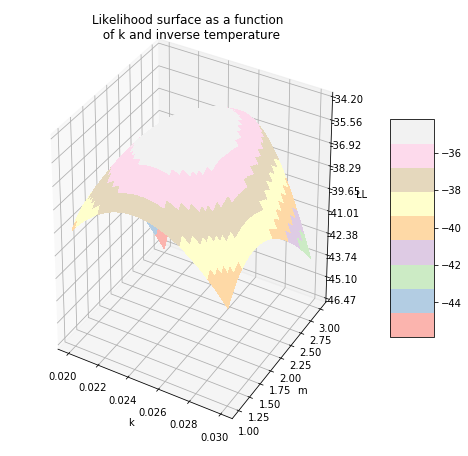

In [224]:
#plot likelihood surface
fig = plt.figure(figsize = (8,8))
plt.set_cmap('Blues')
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(ks, ms)
Z = np.array([float(df[(df['ks'] == x) & (df['m'] == y)]['LL']) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.xlabel('k')
plt.ylabel('m')
ax.set_zlabel('LL')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.Pastel1,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=.5, aspect=5)
plt.title('Likelihood surface as a function \n of k and inverse temperature')
plt.savefig('TD_likelihood_surface.svg',dpi = 300)
plt.show()

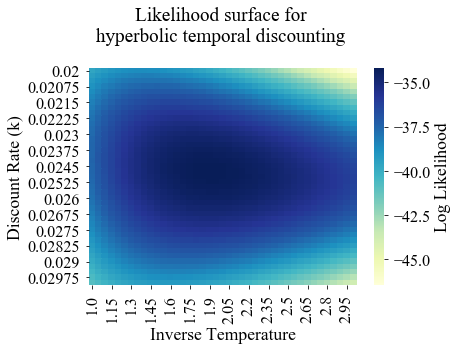

In [239]:
# df['logk'] = map(lambda x: round(x,2),map(np.log, df['ks']))
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (10, 10)})
df2 = df.pivot("ks", "m", "LL")
sns.heatmap(df2, cmap="YlGnBu", 
            linewidths = 0,
            rasterized=True,
            cbar_kws={'label': 'Log Likelihood'})
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.xlabel('Inverse Temperature')
plt.ylabel('Discount Rate (k)')

plt.title('Likelihood surface for \n hyperbolic temporal discounting  \n')
plt.savefig('TD_likelihood_surface_heatmap.svg',dpi = 300)

The energy function is well-behaved in the k dimension: it shows a monotonically decreasing function around the global maximum. In the m dimension, the function is much flatter, which reflects the fact that a wider range of m's provide a similar account of choice data. This makes sense because m is unbounded for noiseless responding. Importantly, there does not appear to be a trade-off between k and m (which would be evident as a long, diagonal basin of attraction around the global maximum. This would be a problem because it suggests that only slightly different data could have resulted in very different ML estimates.

In [227]:
df[df['LL'] == max(df['LL'])]

,ks,m,LL
797,0.02475,1.9,-34.195355


The maximum of this function is close to the true k, but not very close to the true m